Digital Transformation Training Optimization

Overview:
I wanted to use UCS and A* search for comparison of the best path to optimize a training program at work. I need to know where to invest in training (company location and job function) to make the biggest impact/increase in DXR score in 12 weeks.

Business Problem: My company (Calgon Carbon) is embracing a Digital Transformation set forth by our parent company, Kuraray, and I am tasked with increasing DX readiness across the company with training (increase score from 2 to 5 (max of 10) in 12 weeks total with training).

Goal: This project uses AI Search (Uniform Cost Search and A*) to optimize training across 3 locations to increase DX capability in 12 weeks for employees, using training time (weeks) as the cost metric (using simulated training metrics) to determine where to allocate training resources to make the biggest impact (by increasing overall DXR Score).

This program uses simulation data for training of 3 groups of employees: Operations, Project Managers, and Quality. This includes employees at 3 locations: Headquarters (HQ) and two plants, Big Sandy in KY (BSP) and Pearl River in MS (PRP)

The workforce currently has entry level DX capability across the company (all employees and locations DXR Score 2 out of 10) with limited automation lteracy and inconsistent data skills. Training must be improved across three key roles (Operations, Project Management, Quality) at each location HQ, BSP, PRP within 12 weeks. Each training has a different impact score and time involvement based on location and job function.

Output: Top 5 training roadmap strategies by efficiency (UCS and A*) Value = best path to transform workforce DX skills in 12 weeks. DXR Score (Digital Transformation Readiness Score) improves by minimum 3 pts from 2 to 5 (on scale of 1-10, 10 being the highest). Creates .CSV files for UCS and A* as “DXR Roadmaps” and compares outputs in a Gantt chart. 


In [12]:
#1. Imports and configuration
import math
from heapq import heappush, heappop
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt

#Display
pd.set_option("display.max_colwidth", 200)

#CCC DX Configuration (Simulation, edit with real data!)
BUDGET_WEEKS = 12.0
BASELINE_DXR = 2.0
TARGET_DXR = 5.0
SITES = {"HQ", "BSP", "PRP"}
ROLES = {"Operations", "Project Management", "Quality"}


Using simulated data, update training information with real data.

In [13]:
#2. Data Setup & Validation (Simulation, edit with real data!)
@dataclass(frozen=True)
class Training:
    role: str
    site: str
    track: str
    effort_weeks: float
    dxr_gain: float

trainings: List[Training] = [
    Training("Operations", "HQ", "Industry 4.0", 4.0, 1.2),
    Training("Project Management", "HQ", "Lean DX", 4.0, 1.1),
    Training("Quality", "HQ", "Six Sigma Yellow", 4.0, 1.7),
    Training("Operations", "BSP", "Lean Foundations", 3.0, 0.9),
    Training("Project Management", "BSP", "Agile Basics", 3.0, 0.8),
    Training("Quality", "BSP", "Power BI Intro", 4.0, 1.0),
    Training("Operations", "PRP", "Kaizen Intro", 3.0, 0.8),
    Training("Project Management", "PRP", "Project Controls", 4.0, 1.0),
    Training("Quality", "PRP", "Six Sigma White", 3.0, 0.9),
]

def validate_data(items: List[Training]) -> None:
    seen = set()
    for t in items:
        assert t.site in SITES, f"Unexpected site: {t.site}"
        assert t.role in ROLES, f"Unexpected role: {t.role}"
        key = (t.role, t.site, t.track)
        if key in seen:
            raise ValueError(f"Duplicate training option: {key}")
        seen.add(key)
        if t.effort_weeks <= 0 or t.dxr_gain <= 0:
            raise ValueError(f"Non-positive values for {key}")
validate_data(trainings)
print("Data validation passed!")


Data validation passed!


UCS: Minimize Weeks to Reach Target DXR
UCS guarantees the minimum total cost (weeks) to reach the goal when costs are non‑negative, which matches the objective “fastest plan to DXR ≥ 5”.
UCS searches by expanding plans in order of total weeks. The first goal popped is optimal in weeks, then gathers all tie‑optimal plans with the same week count and rank them by DXR gain for business value.


In [14]:
#3. UCS (minimize weeks to reach target DXR)
def ucs_min_weeks(trainings: List[Training], budget=BUDGET_WEEKS, top_k=5):
    pq = []
    heappush(pq, (0.0, 0.0, tuple()))  #(weeks, gain, chosen_indices)
    seen_best_weeks = {}
    min_goal_weeks = None
    optimal = []

    items = list(enumerate(trainings))

    while pq:
        weeks, gain, chosen = heappop(pq)
        if min_goal_weeks is not None and weeks > min_goal_weeks + 1e-9:
            break

        if BASELINE_DXR + gain >= TARGET_DXR:
            if min_goal_weeks is None:
                min_goal_weeks = weeks
            if abs(weeks - min_goal_weeks) < 1e-9:
                plan = [trainings[i] for i in chosen]
                optimal.append((plan, gain, weeks))
            continue

        S = frozenset(chosen)
        if seen_best_weeks.get(S, float('inf')) <= weeks:
            continue
        seen_best_weeks[S] = weeks

        chosen_set = set(chosen)
        for i, t in items:
            if i in chosen_set:
                continue
            w2 = weeks + t.effort_weeks
            if w2 > budget:
                continue
            g2 = gain + t.dxr_gain
            c2 = tuple(sorted(chosen + (i,)))
            heappush(pq, (w2, g2, c2))

    optimal.sort(key=lambda x: (-x[1], x[2]))
    return min_goal_weeks, optimal[:top_k]

min_weeks, optimal_ucs = ucs_min_weeks(trainings, budget=BUDGET_WEEKS, top_k=5)
if min_weeks is None:
    print("No plan can reach DXR target within 12 weeks.")
else:
    print(f"Optimal (fewest weeks) to reach target: {min_weeks:.1f} weeks")
    for i, (plan, gain, weeks) in enumerate(optimal_ucs, 1):
        eff = gain / weeks if weeks else float('inf')
        print(f"\nUCS #{i}: Weeks {weeks:.1f} | DXR +{gain:.1f} | Eff {eff:.2f} DXR/week") 
        for t in plan:
            print(f"   - {t.site} {t.role} — {t.track} ({t.effort_weeks}w, +{t.dxr_gain})")


Optimal (fewest weeks) to reach target: 10.0 weeks

UCS #1: Weeks 10.0 | DXR +3.5 | Eff 0.35 DXR/week
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)
   - BSP Operations — Lean Foundations (3.0w, +0.9)
   - PRP Quality — Six Sigma White (3.0w, +0.9)

UCS #2: Weeks 10.0 | DXR +3.5 | Eff 0.35 DXR/week
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)
   - BSP Operations — Lean Foundations (3.0w, +0.9)
   - PRP Quality — Six Sigma White (3.0w, +0.9)

UCS #3: Weeks 10.0 | DXR +3.5 | Eff 0.35 DXR/week
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)
   - BSP Operations — Lean Foundations (3.0w, +0.9)
   - PRP Quality — Six Sigma White (3.0w, +0.9)

UCS #4: Weeks 10.0 | DXR +3.4 | Eff 0.34 DXR/week
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)
   - BSP Operations — Lean Foundations (3.0w, +0.9)
   - BSP Project Management — Agile Basics (3.0w, +0.8)

UCS #5: Weeks 10.0 | DXR +3.4 | Eff 0.34 DXR/week
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)
   - BSP Operations — Lean Foundations (3.0w, 

In [15]:
#4. UCS KPIs table
def summarize(plans):
    rows = []
    for i, (plan, gain, weeks) in enumerate(plans, 1):
        rows.append({
            "Rank": i, 
            "Weeks Needed": weeks, 
            "DXR Gain": gain, 
            "Final DXR": BASELINE_DXR + gain,
            "# of Sites": len(set(t.site for t in plan)),
            "Roadmap": " | ".join(f"{t.site} {t.role} — {t.track} ({t.effort_weeks}w, +{t.dxr_gain})" for t in plan)
        })
    return pd.DataFrame(rows)

if min_weeks is not None:
    df_ucs = summarize(optimal_ucs)
    display(df_ucs)
    df_ucs.to_csv("dxr_ucs_results.csv", index=False)
    print("Saved: dxr_ucs_results.csv")


,Rank,Weeks Needed,DXR Gain,Final DXR,# of Sites,Roadmap
0,1,10.0,3.5,5.5,3,"HQ Quality — Six Sigma Yellow (4.0w, +1.7) | BSP Operations — Lean Foundations (3.0w, +0.9) | PRP Quality — Six Sigma White (3.0w, +0.9)"
1,2,10.0,3.5,5.5,3,"HQ Quality — Six Sigma Yellow (4.0w, +1.7) | BSP Operations — Lean Foundations (3.0w, +0.9) | PRP Quality — Six Sigma White (3.0w, +0.9)"
2,3,10.0,3.5,5.5,3,"HQ Quality — Six Sigma Yellow (4.0w, +1.7) | BSP Operations — Lean Foundations (3.0w, +0.9) | PRP Quality — Six Sigma White (3.0w, +0.9)"
3,4,10.0,3.4,5.4,2,"HQ Quality — Six Sigma Yellow (4.0w, +1.7) | BSP Operations — Lean Foundations (3.0w, +0.9) | BSP Project Management — Agile Basics (3.0w, +0.8)"
4,5,10.0,3.4,5.4,2,"HQ Quality — Six Sigma Yellow (4.0w, +1.7) | BSP Operations — Lean Foundations (3.0w, +0.9) | BSP Project Management — Agile Basics (3.0w, +0.8)"


Saved: dxr_ucs_results.csv


A* Search: Maximizes DXR Gain within 12‑Week Cap.
This variant maximizes DXR gain subject to ≤ 12 weeks.

In [17]:
#5. A* search with admissible heuristic
def upper_bound_gain(items: List[Training], remaining_weeks: float) -> float:
    if remaining_weeks <= 1e-9 or not items:
        return 0.0
    by_ratio = sorted(items, key=lambda t: t.dxr_gain / t.effort_weeks, reverse=True)
    total, used = 0.0, 0.0
    for t in by_ratio:
        if used + t.effort_weeks <= remaining_weeks:
            used += t.effort_weeks
            total += t.dxr_gain
        else:
            remain = remaining_weeks - used
            if remain > 1e-9:
                total += t.dxr_gain * (remain / t.effort_weeks)
            break
    return total

def astar_max_gain(trainings: List[Training], CAP=BUDGET_WEEKS, top_k=5):
    n = len(trainings)
    all_idx = tuple(range(n))

    def priority(gain, rem_items, remaining):
        return -(gain + upper_bound_gain(rem_items, remaining))

    start = (priority(0.0, trainings, CAP), 0.0, 0.0, tuple(), all_idx)
    pq = [start]
    incumbent = 0.0
    best = []
    seen = set()

    while pq:
        _, weeks, gain, chosen, rem = heappop(pq)
        remaining = CAP - weeks
        rem_items = [trainings[i] for i in rem]

        if gain + upper_bound_gain(rem_items, remaining) <= incumbent + 1e-9:
            continue

        for i in list(rem):
            t = trainings[i]
            new_rem = tuple(j for j in rem if j != i)

            #take
            if weeks + t.effort_weeks <= CAP:
                w2, g2 = weeks + t.effort_weeks, gain + t.dxr_gain
                c2 = tuple(sorted(chosen + (i,)))
                key = (round(w2,2), round(g2,2), c2)
                if key not in seen:
                    seen.add(key)
                    pr = priority(g2, [trainings[j] for j in new_rem], CAP - w2)
                    heappush(pq, (pr, w2, g2, c2, new_rem))
                    if g2 > incumbent:
                        incumbent = g2
                        best.append((c2, g2, w2))

            #skip
            key_skip = (round(weeks,2), round(gain,2), chosen, new_rem)
            if key_skip not in seen:
                seen.add(key_skip)
                pr_skip = priority(gain, [trainings[j] for j in new_rem], remaining)
                heappush(pq, (pr_skip, weeks, gain, chosen, new_rem))

        best = sorted(set(best), key=lambda x: (-x[1], x[2]))[:max(top_k, 5)]

    results = []
    for chosen_idx, g, w in best[:top_k]:
        plan = [trainings[i] for i in chosen_idx]
        results.append((plan, g, w))
    return results

best_astar = astar_max_gain(trainings, CAP=BUDGET_WEEKS, top_k=5)
for i, (plan, gain, weeks) in enumerate(best_astar, 1):
    eff = gain / weeks if weeks else float('inf')
    print(f"\nA* #{i}: Weeks {weeks:.1f} | DXR +{gain:.1f} | Eff {eff:.2f} DXR/week") 
    for t in plan:
        print(f"   - {t.site} {t.role} — {t.track} ({t.effort_weeks}w, +{t.dxr_gain})")



A* #1: Weeks 12.0 | DXR +4.0 | Eff 0.33 DXR/week
   - HQ Operations — Industry 4.0 (4.0w, +1.2)
   - HQ Project Management — Lean DX (4.0w, +1.1)
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)

A* #2: Weeks 11.0 | DXR +3.8 | Eff 0.35 DXR/week
   - HQ Operations — Industry 4.0 (4.0w, +1.2)
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)
   - BSP Operations — Lean Foundations (3.0w, +0.9)

A* #3: Weeks 10.0 | DXR +3.5 | Eff 0.35 DXR/week
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)
   - BSP Operations — Lean Foundations (3.0w, +0.9)
   - PRP Quality — Six Sigma White (3.0w, +0.9)

A* #4: Weeks 10.0 | DXR +3.0 | Eff 0.30 DXR/week
   - HQ Operations — Industry 4.0 (4.0w, +1.2)
   - BSP Operations — Lean Foundations (3.0w, +0.9)
   - PRP Quality — Six Sigma White (3.0w, +0.9)

A* #5: Weeks 8.0 | DXR +2.9 | Eff 0.36 DXR/week
   - HQ Operations — Industry 4.0 (4.0w, +1.2)
   - HQ Quality — Six Sigma Yellow (4.0w, +1.7)


In [18]:
#6. A* Search KPIs table
df_astar = summarize(best_astar)
display(df_astar)
df_astar.to_csv("dxr_astar_results.csv", index=False)
print("Saved: dxr_astar_results.csv")


,Rank,Weeks Needed,DXR Gain,Final DXR,# of Sites,Roadmap
0,1,12.0,4.0,6.0,1,"HQ Operations — Industry 4.0 (4.0w, +1.2) | HQ Project Management — Lean DX (4.0w, +1.1) | HQ Quality — Six Sigma Yellow (4.0w, +1.7)"
1,2,11.0,3.8,5.8,2,"HQ Operations — Industry 4.0 (4.0w, +1.2) | HQ Quality — Six Sigma Yellow (4.0w, +1.7) | BSP Operations — Lean Foundations (3.0w, +0.9)"
2,3,10.0,3.5,5.5,3,"HQ Quality — Six Sigma Yellow (4.0w, +1.7) | BSP Operations — Lean Foundations (3.0w, +0.9) | PRP Quality — Six Sigma White (3.0w, +0.9)"
3,4,10.0,3.0,5.0,3,"HQ Operations — Industry 4.0 (4.0w, +1.2) | BSP Operations — Lean Foundations (3.0w, +0.9) | PRP Quality — Six Sigma White (3.0w, +0.9)"
4,5,8.0,2.9,4.9,1,"HQ Operations — Industry 4.0 (4.0w, +1.2) | HQ Quality — Six Sigma Yellow (4.0w, +1.7)"


Saved: dxr_astar_results.csv


UCS vs A*
UCS is best when the objective is minimize total cost (weeks) to hit threshold (DXR ≥ target). UCS is optimal and uninformed (no heuristic needed).
A* with an admissible bound is best when the objective is maximize impact within a fixed budget (12 weeks). It remains optimal, often expanding far fewer nodes than brute force thanks to bounding.
These serve different decision questions UCS: “How fast can we reach target?”  A*: “What’s the biggest increase we can get in our fixed time?”.


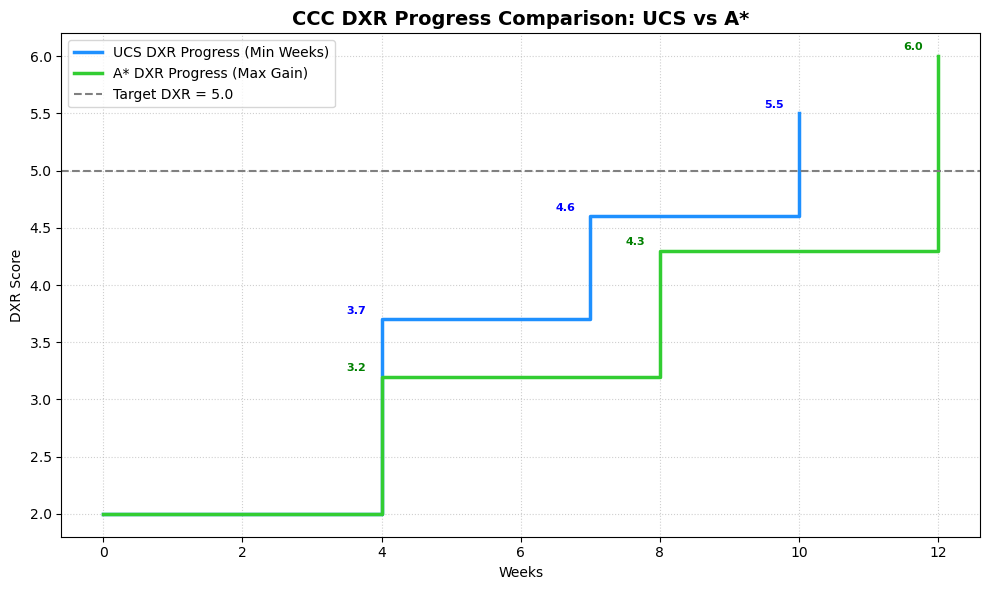

In [19]:
#6. Gantt Chart Comparing UCS and A*

import matplotlib.pyplot as plt

if optimal_ucs and best_astar:
    plan_ucs = optimal_ucs[0][0]  #best UCS plan
    plan_astar = best_astar[0][0]  #best A* plan

    #Function to compute cumulative DXR and time
    def cumulative_progress(plan):
        dxr, weeks, dxr_points, week_points, labels = BASELINE_DXR, 0.0, [], [], []
        for t in plan:
            weeks += t.effort_weeks
            dxr += t.dxr_gain
            dxr_points.append(dxr)
            week_points.append(weeks)
            labels.append(f"{t.site} {t.role} — {t.track}")
        return week_points, dxr_points, labels

    weeks_ucs, dxr_ucs, labels_ucs = cumulative_progress(plan_ucs)
    weeks_astar, dxr_astar, labels_astar = cumulative_progress(plan_astar)

    #Plot setup
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ###UCS path
    ax1.step([0] + weeks_ucs, [BASELINE_DXR] + dxr_ucs, where="post", 
             label="UCS DXR Progress (Min Weeks)", color="dodgerblue", linewidth=2.5)
    for w, d in zip(weeks_ucs, dxr_ucs):
        ax1.text(w - 0.5, d + 0.05, f"{d:.1f}", color="blue", fontsize=8, weight="bold")

    ###A* path
    ax1.step([0] + weeks_astar, [BASELINE_DXR] + dxr_astar, where="post", 
             label="A* DXR Progress (Max Gain)", color="limegreen", linewidth=2.5)
    for w, d in zip(weeks_astar, dxr_astar):
        ax1.text(w - 0.5, d + 0.05, f"{d:.1f}", color="green", fontsize=8, weight="bold")

    #Formatting
    ax1.axhline(y=TARGET_DXR, color="gray", linestyle="--", label=f"Target DXR = {TARGET_DXR}")
    ax1.set_xlabel("Weeks")
    ax1.set_ylabel("DXR Score")
    ax1.set_title("CCC DXR Progress Comparison: UCS vs A*", fontsize=14, weight="bold")
    ax1.legend()
    ax1.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Need both UCS and A* results to generate DXR progression chart.")


UCS plan reaches DXR 5.0 threshold by week 10, while A* takes the full 12 weeks to achieve higher final readiness of 6.0. This Gantt chart is a visual that shows the tradeoff between speed (UCS) and total impact (A*).